#Imports & Installs

In [ ]:
import time
import numpy as np
import cv2
import PIL
from scipy.signal import convolve2d, correlate2d, fftconvolve
from matplotlib import pyplot as plt
from typing import List
from google.colab.patches import cv2_imshow
from skimage.transform import rescale
from PIL import Image
from scipy.ndimage import convolve, correlate
from numpy.fft import *
from mpl_toolkits.mplot3d.axes3d import *

In [ ]:
!gdown 1L009tmj6opL79TwotMhl7KLeoFkMjYXI

Downloading...
From: https://drive.google.com/uc?id=1L009tmj6opL79TwotMhl7KLeoFkMjYXI
To: /content/data.zip
100% 3.93M/3.93M [00:00<00:00, 178MB/s]


In [ ]:
!unzip './data.zip'

Archive:  ./data.zip
replace data/pair/bicycle.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/pair/bicycle.bmp   
  inflating: data/pair/motorcycle.bmp  
  inflating: data/pair2/einstein.bmp  
  inflating: data/pair2/marilyn.bmp  
  inflating: data/pair3/fish.bmp     
  inflating: data/pair3/submarine.bmp  
  inflating: data/pair4/bird.bmp     
  inflating: data/pair4/plane.bmp    
  inflating: data/pair5/cat.bmp      
  inflating: data/pair5/dog.bmp      
  inflating: data/pair6/cat.jpg      
  inflating: data/pair6/man.jpg      
  inflating: data/pair7/cat.jpg      
  inflating: data/pair7/H.jpg        
  inflating: RISDance.jpg            


#Code

##Functions & Testing

###Visualization Functions

In [ ]:
def plot_figure(image_list: List[np.ndarray], title_list: List[str], height, width, cmap='gray'):
    """ Plot multiple images
    """
    assert len(image_list) == len(title_list)
    assert height > 0
    assert width > 0
    for i in range(len(image_list)):

        if cmap == 'gray':
            plt.subplot(height, width, i + 1), plt.imshow(image_list[i], cmap=cmap)
        elif cmap == 'rgb':
            plt.subplot(height, width, i + 1), plt.imshow(image_list[i])
        elif cmap == 'bgr':
            plt.subplot(height, width, i + 1), plt.imshow(cv2.cvtColor(image_list[i].astype(np.uint8), cv2.COLOR_BGR2RGB))
        else:
            plt.subplot(height, width, i + 1), plt.imshow(image_list[i], cmap=cmap)

        plt.title(title_list[i])
        plt.box(on=None)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
def vis_hybrid_image(hybrid_image):
    #visualize a hybrid image by progressively downsampling the image and
    #concatenating all of the images together.

    scales = 5 #how many downsampled versions to create
    scale_factor = 0.5 #how much to downsample each time
    res = hybrid_image
    image_list=[PIL.Image.fromarray(cv2.cvtColor(hybrid_image.astype(np.uint8), cv2.COLOR_BGR2RGB))]
    for i in range(1,scales):
      #new_size=(int(res.shape[0]*scale_factor),int(res.shape[1]*scale_factor))
      #m1, m2 = new_size
      #x_center = (n1 - m1) // 2
      #y_center = (n2 - m2) // 2
      #padded_image = np.ones((n1, n2, channels))*255
      res = rescale(res, scale_factor, mode='reflect', channel_axis=2)
      #padded_image[n1-m2:n2, y_center:y_center+m1] = res
      image_list.append(PIL.Image.fromarray(cv2.cvtColor(res.astype(np.uint8), cv2.COLOR_BGR2RGB)))


    widths, heights = zip(*(i.size for i in image_list))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height), (255,255,255))

    x_offset = 0
    for im in image_list:
      new_im.paste(im, (x_offset,max_height-im.size[1]))
      x_offset += im.size[0]
    plt.figure(figsize=(15, 15))
    plt.box(on=None)
    plt.xticks([]), plt.yticks([])
    plt.imshow(new_im)

###im_filter Function

In [ ]:
def im_filter(image:np.ndarray, filter:np.ndarray, pad_type='zero'):
  """
  Your function should meet the requirements laid out on the project webpage.
  Apply a filter to an image. Return the filtered image.
  Inputs:
  - image -> numpy nd-array of dim (m, n, c) for RGB images or numpy nd-array of dim (m, n) for gray scale images
  - filter -> numpy nd-array of odd dim (k, l)
  Returns
  - filtered_image -> numpy nd-array of dim (m, n, c) or numpy nd-array of dim (m, n)
  Errors if:
  - filter has any even dimension -> raise an Exception with a suitable error message.
  """

  # return an error message for even
  assert filter.shape[0]%2 + filter.shape[1]%2  > 1  , "filter dimensions can not be even"

  n1, n2 = image.shape[0], image.shape[1]
  m1, m2 = filter.shape[0], filter.shape[1]
  # rotate kernel by 180 degrees
  filter = np.flipud(np.fliplr(filter))

  if len(image.shape)==3:
    channels=3
  elif len(image.shape)==2:
    channels=1
    #to make a general conv that is not affected by channel indexing
    image=np.reshape(image,(n1,n2,1))
  else:
    raise Exception("Error With Image Dims!")


  padded_image = np.zeros((n1+m1-1, n2+m2-1, channels))
  output = np.zeros((n1, n2, channels))
  # pad the image
  x_center = (m1-1) // 2
  y_center = (m2-1) // 2
  if pad_type.lower() =='reflect':
    padded_image = np.pad(image, pad_width=((x_center, y_center+1), (x_center, y_center+1), (0, 0)), mode='symmetric')
  elif pad_type.lower() =='zero':
    padded_image[x_center:x_center+n1, y_center:y_center+n2, :] = image
  else:
    raise Exception("No such padding type")


  # for each channel
  for c in range(channels):
    # for each row
    for x in range(n1):
      # for each pixel
      for y in range(n2):
        output[x,y,c] = np.sum(filter * padded_image[x:x+m1, y:y+m2,c])

  if(channels>1):
    return output
  else:
    return np.reshape(output, (n1,n2))

####Testing

time taken to excute our corr 7.754995822906494
time taken to excute built-in 0.029622793197631836


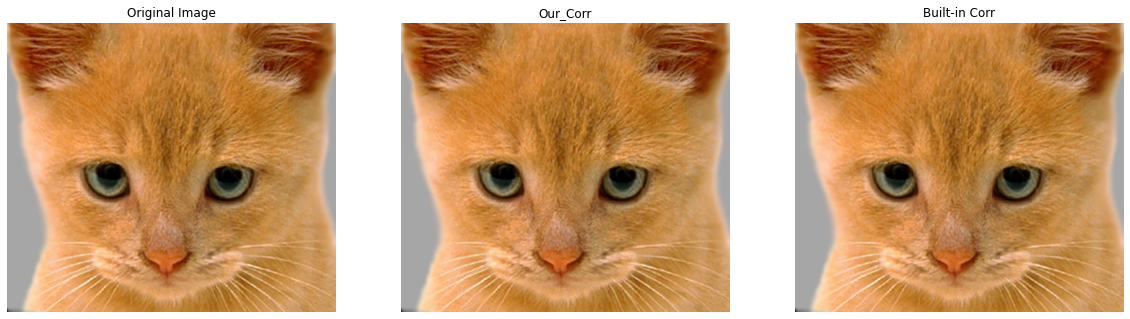

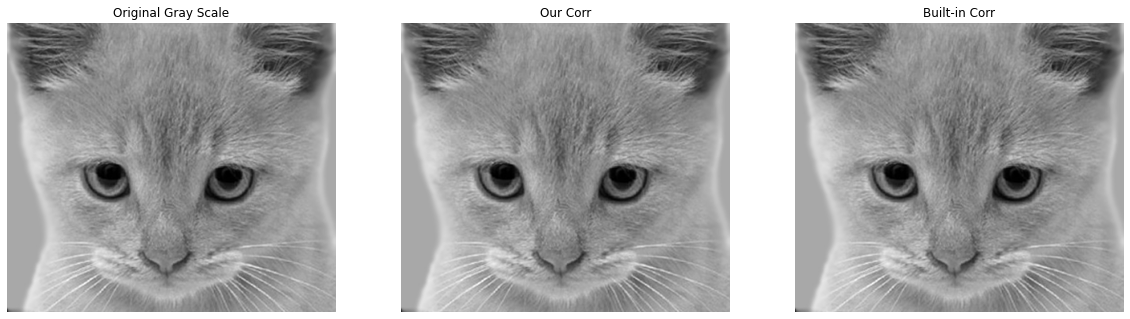

Did we get the same sizes? Yes
Did we get the same results? Yes
Did we get the same image after identity filter? Yes


In [ ]:
identity_filter = np.asarray([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)

# load any image
img = cv2.imread('./data/pair5/cat.bmp')
ref_colored = np.array(img)
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

st = time.time()
# try our function
out_colored = im_filter(img,identity_filter)
out_gray = im_filter(grayscale,identity_filter)

et = time.time()
elapsed_time = et - st
print("time taken to excute our corr {}".format(elapsed_time))

st = time.time()
# try built-in
ref_colored[:,:,0] = correlate2d(img[:,:,0], identity_filter, 'same')
ref_colored[:,:,1] = correlate2d(img[:,:,1], identity_filter, 'same')
ref_colored[:,:,2] = correlate2d(img[:,:,2], identity_filter, 'same')
ref_gray = correlate2d(grayscale, identity_filter, 'same')

et = time.time()
elapsed_time = et - st
print("time taken to excute built-in {}".format(elapsed_time))

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([img, out_colored, ref_colored], ['Original Image', 'Our_Corr', 'Built-in Corr'], 2, 3, 'bgr')
plt.figure(figsize=(20, 20))
plot_figure([grayscale, out_gray, ref_gray], ['Original Gray Scale', 'Our Corr', 'Built-in Corr'], 2, 3, 'gray')

# check sizes
cond = int(np.all(img.shape == out_colored.shape) and np.all(grayscale.shape == out_gray.shape))
print("Did we get the same sizes? "+ cond*"Yes" + (1-cond) *"No")

# check values
cond = int(np.all(ref_colored == out_colored) and np.all(ref_gray == out_gray))
print("Did we get the same results? "+ cond*"Yes" + (1-cond) *"No")

# check values
cond = int(np.all(img == out_colored) and np.all(grayscale == out_gray))
print("Did we get the same image after identity filter? "+ cond*"Yes" + (1-cond) *"No")

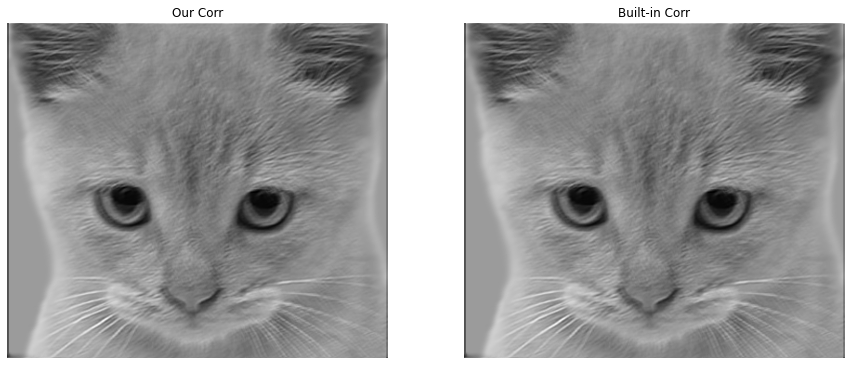

Did we get the same sizes? Yes
Did we get the same results? Yes


In [ ]:
# 3x5 filter
filter = np.asarray([[-1, 0, -1, 0, 2], [1, 0, 3, 0, 1], [1, 0, -1, 0, -1]], dtype=np.float32)
out_gray = im_filter(grayscale, filter)
ref_gray = convolve2d(grayscale, filter, 'same')

# draw images
plt.figure(figsize=(15, 15))
plot_figure([out_gray, ref_gray], ['Our Corr', 'Built-in Corr'], 1, 2, 'gray')

# check sizes
cond = int(np.all(ref_gray.shape == out_gray.shape))
print("Did we get the same sizes? "+ cond*"Yes" + (1-cond) *"No")

# check values
cond = int(np.all(ref_gray == out_gray))
print("Did we get the same results? "+ cond*"Yes" + (1-cond) *"No")

In [ ]:
# 3x4 filter
filter = np.asarray([[-1, 0, -1, 0], [1, 0, 3, 0], [-1, 0, -1, 0]], dtype=np.float32)
out_gray = im_filter(grayscale, filter)
ref_gray = correlate2d(grayscale, filter, 'same')

# draw images
plt.figure(figsize=(15, 15))
plot_figure([out_gray, ref_gray], ['Our Corr', 'Built-in Corr'], 1, 2, 'gray')

# check sizes
cond = int(np.all(ref_gray.shape == out_gray.shape))
print("Did we get the same sizes? "+ cond*"Yes" + (1-cond) *"No")

# check values
cond = int(np.all(ref_gray == out_gray))
print("Did we get the same results? "+ cond*"Yes" + (1-cond) *"No")

AssertionError: ignored

In [ ]:
# 2x2 filter
filter = np.asarray([[0, 1], [1,0]], dtype=np.float32)
out_gray = im_filter(grayscale, filter)

AssertionError: ignored

In [ ]:
# 2x1 filter
filter = np.asarray([[0, 1]], dtype=np.float32)
out_gray = im_filter(grayscale, filter)

AssertionError: ignored

###im_filter_fft Function

In [ ]:
def im_filter_fft(image:np.ndarray, filter:np.ndarray):
  """
  Your function should meet the requirements laid out on the project webpage.
  Apply a filter to an image. Return the filtered image.
  Inputs:
  - image -> numpy nd-array of dim (m, n, c) for RGB images or numpy nd-array of dim (m, n) for gray scale images
  - filter -> numpy nd-array of odd dim (k, l)
  Returns
  - filtered_image -> numpy nd-array of dim (m, n, c) or numpy nd-array of dim (m, n)
  Errors if:
  - filter has any even dimension -> raise an Exception with a suitable error message.
  """

  # return an error message for even
  assert filter.shape[0]%2 + filter.shape[1]%2  > 1  , "filter dimensions can not be even"

  # rotate kernel by 180 degrees
  # filter = np.flipud(np.fliplr(filter))

  # get sizes of image and kernel
  img_size = np.array(image.shape)
  ker_size = np.array(filter.shape)
  if(len(img_size)==3):img_size=img_size[:-1]
  # calculate the size of output
  size = img_size + ker_size-1
  # now we need to pad to the nearest power of 2 for speed related reasons
  fsize = 2 ** np.ceil(np.log2(size)).astype(int)
  # calculate the slice that contains the output that has the size of the image
  newsize = np.asarray(img_size)
  currsize = np.array(size)
  startind = (currsize - newsize) // 2
  endind = startind + newsize
  # turn the slice into tuple to be able to index with
  imgslice = tuple([slice(startind[k], endind[k]) for k in range(len(endind))])

  #do Filtering
  if(len(image.shape)==3):
    #create a temp output
    output = np.zeros((image.shape))
    # for each channel
    for c in range(3):
      # get real componenet of result since fft has both real and complex
      output[:, :, c] = np.real(ifftn(fftn(image[:, :, c], fsize) * fftn(filter, fsize))[imgslice].copy())
    filtered_img=output

  elif(len(image.shape)==2):
    filtered_img = np.real(ifft2(fft2(image, fsize) * fft2(filter, fsize))[imgslice].copy())

  else:
    raise Exception("unsupported image dimensions")

  return filtered_img

####Testing

time taken to excute our fft conv 0.12413883209228516
time taken to excute built-in 0.03923225402832031


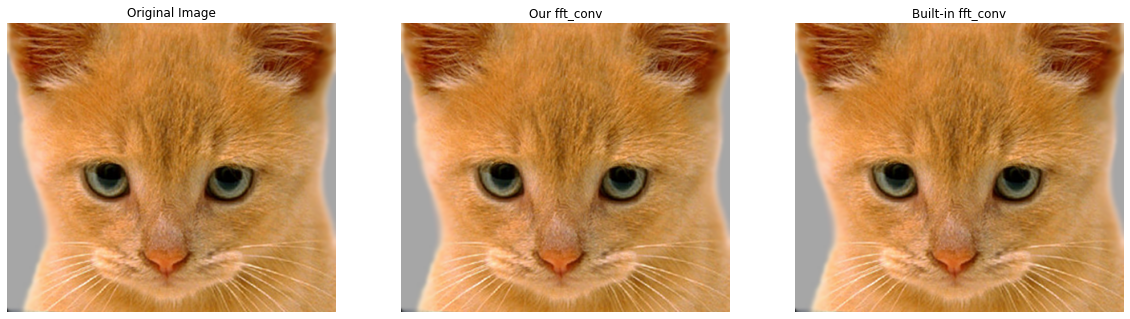

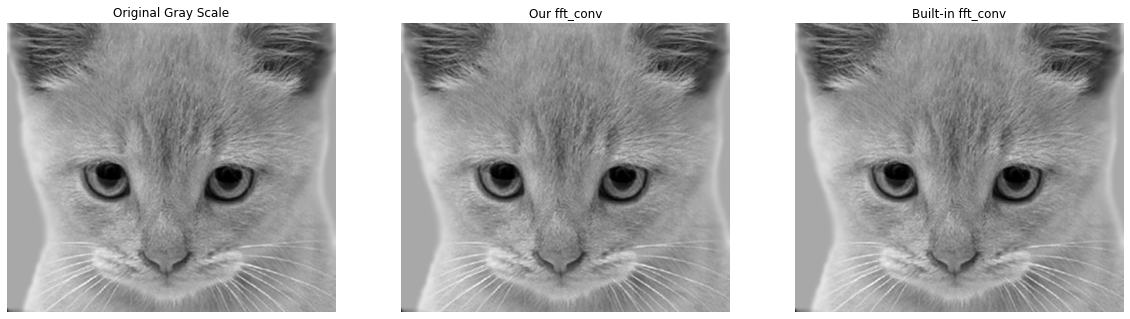

Did we get the same sizes? Yes
Did we get the same results? Yes
Did we get the same image after identity filter? Yes


In [ ]:
identity_filter = np.asarray([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)

# load any image
img = cv2.imread('./data/pair5/cat.bmp')
ref_colored = np.array(img)
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

st = time.time()
# try our function
out_colored = np.round(im_filter_fft(img,identity_filter))
out_gray = np.round(im_filter_fft(grayscale,identity_filter))

et = time.time()
elapsed_time = et - st
print("time taken to excute our fft conv {}".format(elapsed_time))

st = time.time()
# try built-in
ref_colored[:,:,0] = np.round(fftconvolve(img[:,:,0], identity_filter, 'same'))
ref_colored[:,:,1] = np.round(fftconvolve(img[:,:,1], identity_filter, 'same'))
ref_colored[:,:,2] = np.round(fftconvolve(img[:,:,2], identity_filter, 'same'))
ref_gray = np.round(fftconvolve(grayscale, identity_filter, 'same'))

et = time.time()
elapsed_time = et - st
print("time taken to excute built-in {}".format(elapsed_time))

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([img, out_colored, ref_colored], ['Original Image', 'Our fft_conv', 'Built-in fft_conv'], 2, 3, 'bgr')
plt.figure(figsize=(20, 20))
plot_figure([grayscale, out_gray, ref_gray], ['Original Gray Scale', 'Our fft_conv', 'Built-in fft_conv'], 2, 3, 'gray')

# check sizes
cond = int(np.all(img.shape == out_colored.shape) and np.all(grayscale.shape == out_gray.shape))
print("Did we get the same sizes? "+ cond*"Yes" + (1-cond) *"No")

# check values
cond = int(np.all(ref_colored == out_colored) and np.all(ref_gray == out_gray))
print("Did we get the same results? "+ cond*"Yes" + (1-cond) *"No")

# check values
cond = int(np.all(img == out_colored) and np.all(grayscale == out_gray))
print("Did we get the same image after identity filter? "+ cond*"Yes" + (1-cond) *"No")

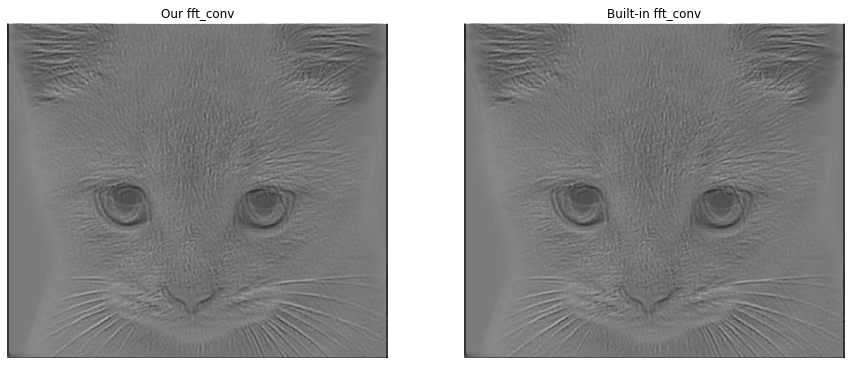

Did we get the same sizes? Yes
Did we get the same results? Yes


In [ ]:
# 3x5 filter
filter = np.asarray([[-1, 0, -1, 0, 5], [5, 0, 3, 0, 1], [1, 0, -9, 0, -1]], dtype=np.float32)
out_gray = np.round(im_filter_fft(grayscale, filter))
ref_gray = np.round(fftconvolve(grayscale, filter, 'same'))

# draw images
plt.figure(figsize=(15, 15))
plot_figure([out_gray, ref_gray], ['Our fft_conv', 'Built-in fft_conv'], 1, 2, 'gray')

# check sizes
cond = int(np.all(ref_gray.shape == out_gray.shape))
print("Did we get the same sizes? "+ cond*"Yes" + (1-cond) *"No")

# check values
cond = int(np.all(ref_gray == out_gray))
print("Did we get the same results? "+ cond*"Yes" + (1-cond) *"No")

### gen_hybrid_image Function

In [ ]:
def normalize_image(image):
    ''' Normalizes a given image to make its values between 0 and 1'''
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min)

def gen_hybrid_image(image1: np.ndarray, image2: np.ndarray, cutoff_frequency: float, ksize=3):
  """
   Inputs:
   - image1 -> The image from which to take the low frequencies.
   - image2 -> The image from which to take the high frequencies.
   - cutoff_frequency -> The standard deviation, in pixels, of the Gaussian
                         blur that will remove high frequencies.

   Task:
   - Use my_imfilter to create 'low_frequencies' and 'high_frequencies'.
   - Combine them to create 'hybrid_image'.
  """

  assert image1.shape == image2.shape , "Images must have the same sizes"

  image1 = normalize_image(image1)
  image2 = normalize_image(image2)

  # Steps:
  # (1) Remove the high frequencies from image1 by blurring it. The amount of
  #     blur that works best will vary with different image pairs
  # generate a gaussian kernel with mean=0 and sigma = cutoff_frequency,
  # Just a heads up but think how you can generate 2D gaussian kernel from 1D gaussian kernel

  x, y = np.meshgrid(np.linspace(-1, 1, ksize),
                       np.linspace(-1, 1, ksize))
  # create the filter
  filter = np.exp(-(x**2 + y**2) / (2 * cutoff_frequency**2))
  kernel = filter / np.sum(filter)

  # Your code here:
  low_frequencies = im_filter_fft(image1, kernel)

  # (2) Remove the low frequencies from image2. The easiest way to do this is to
  #     subtract a blurred version of image2 from the original version of image2.
  #     This will give you an image centered at zero with negative values.
  # Your code here #
  high_frequencies =  image2 - im_filter_fft(image2, kernel)



  # (3) Combine the high frequencies and low frequencies
  # Your code here #
  hybrid_image = low_frequencies + high_frequencies # Replace with your implementation

  # (4) At this point, you need to be aware that values larger than 1.0
  # or less than 0.0 may cause issues in the functions in Python for saving
  # images to disk. These are called in proj1_part2 after the call to
  # gen_hybrid_image().
  # One option is to clip (also called clamp) all values below 0.0 to 0.0,
  # and all values larger than 1.0 to 1.0.
  hybrid_image = np.clip(hybrid_image, 0.0, 1.0)

  # (5) As a good software development practice you may add some checks (assertions) for the shapes
  # and ranges of your results. This can be performed as test for the code during development or even
  # at production!

  return low_frequencies*255., high_frequencies*255., hybrid_image*255.

####Testing

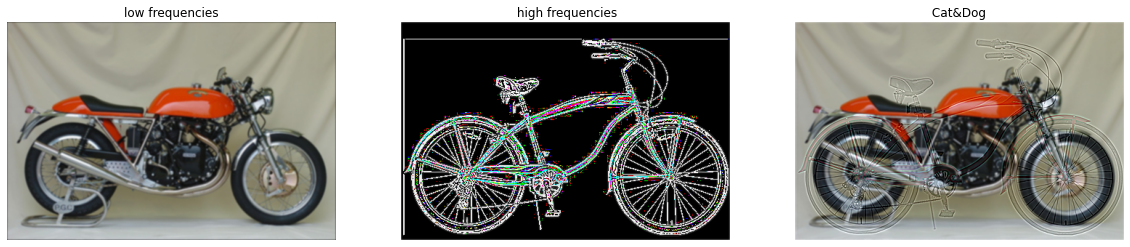

In [ ]:
image1  = cv2.imread('./data/pair/motorcycle.bmp')
image2  = cv2.imread('./data/pair/bicycle.bmp')
#out_gray = im_filter(normalize_image(grayscale), filter)
low_frequencies, high_frequencies, hybrid_image1 = gen_hybrid_image(image1, image2, 0.5, 5)

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([low_frequencies, high_frequencies, hybrid_image1 ], ['low frequencies',' high frequencies',' Cat&Dog '], 1, 3, 'bgr')

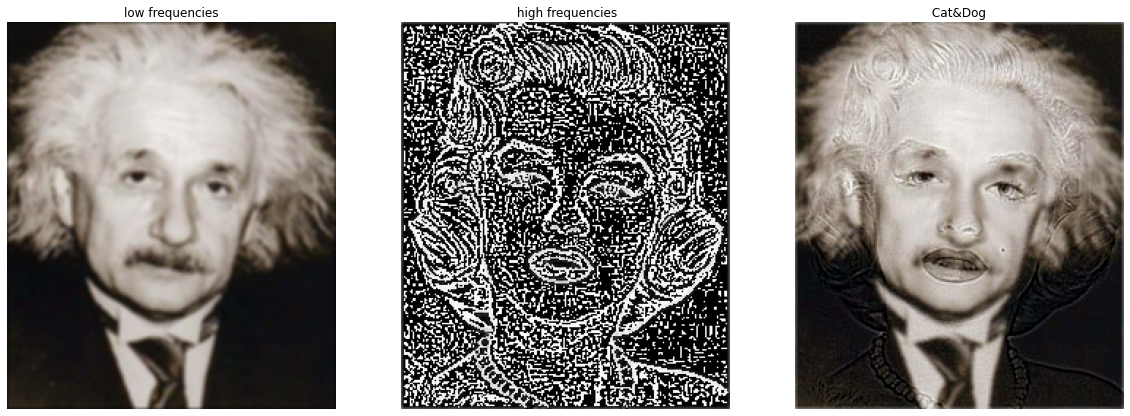

In [ ]:
image1  = cv2.imread('./data/pair2/einstein.bmp')
image2  = cv2.imread('./data/pair2/marilyn.bmp')
#out_gray = im_filter(normalize_image(grayscale), filter)
low_frequencies, high_frequencies, hybrid_image2 = gen_hybrid_image(image1, image2, 0.7, 5)

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([low_frequencies, high_frequencies, hybrid_image2 ], ['low frequencies',' high frequencies',' Cat&Dog '], 1, 3, 'bgr')

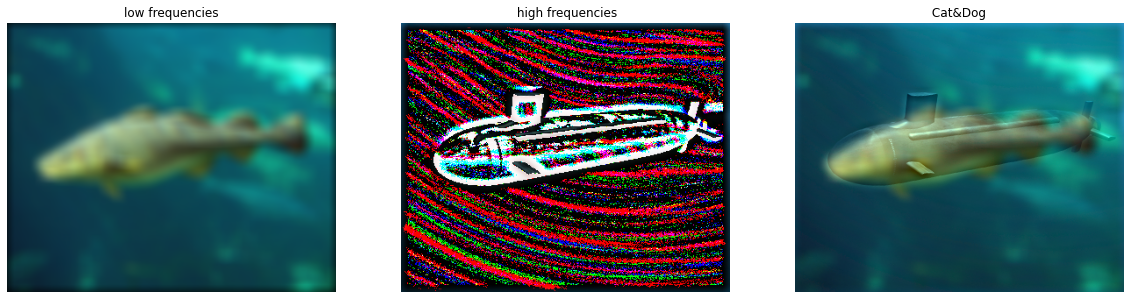

In [ ]:
image1  = cv2.imread('./data/pair3/fish.bmp')
image2  = cv2.imread('./data/pair3/submarine.bmp')
#out_gray = im_filter(normalize_image(grayscale), filter)
low_frequencies, high_frequencies, hybrid_image3 = gen_hybrid_image(image1, image2, 0.9, 17)

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([low_frequencies, high_frequencies, hybrid_image3 ], ['low frequencies',' high frequencies',' Cat&Dog '], 1, 3, 'bgr')

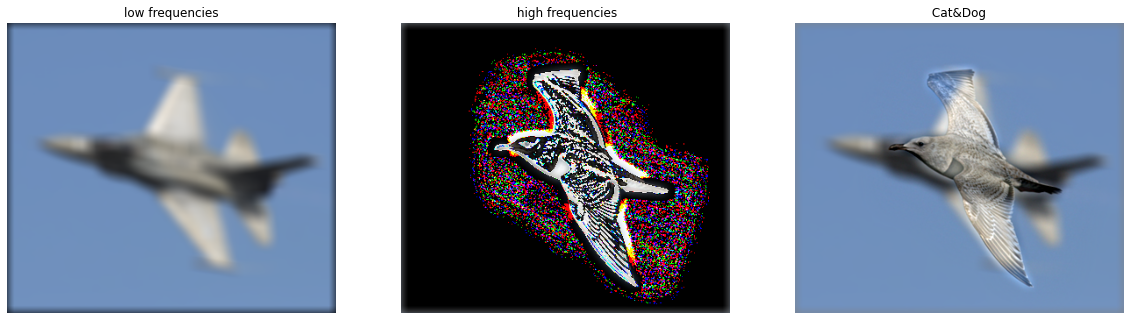

In [ ]:
image1  = cv2.imread('./data/pair4/plane.bmp')
image2  = cv2.imread('./data/pair4/bird.bmp')
#out_gray = im_filter(normalize_image(grayscale), filter)
low_frequencies, high_frequencies, hybrid_image4 = gen_hybrid_image(image1, image2, 0.9, 17)

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([low_frequencies, high_frequencies, hybrid_image4 ], ['low frequencies',' high frequencies',' Cat&Dog '], 1, 3, 'bgr')

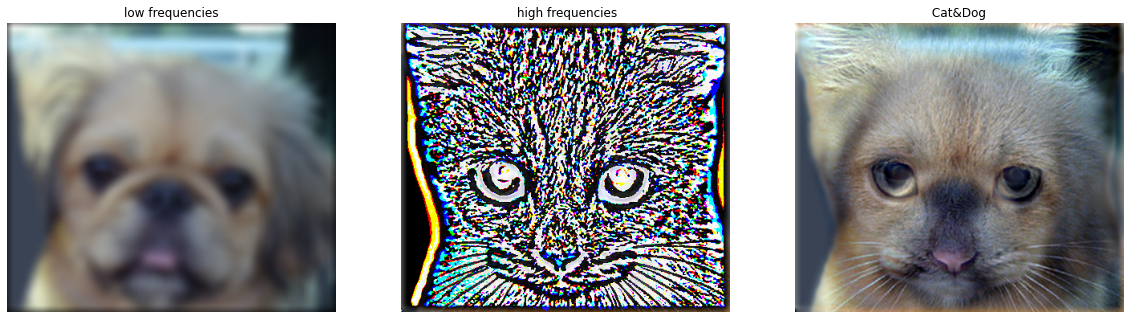

In [ ]:
image1  = cv2.imread('./data/pair5/dog.bmp')
image2  = cv2.imread('./data/pair5/cat.bmp')
#out_gray = im_filter(normalize_image(grayscale), filter)
low_frequencies, high_frequencies, hybrid_image5 = gen_hybrid_image(image1, image2, 0.9, 17)

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([low_frequencies, high_frequencies, hybrid_image5 ], ['low frequencies',' high frequencies',' Cat&Dog '], 1, 3, 'bgr')

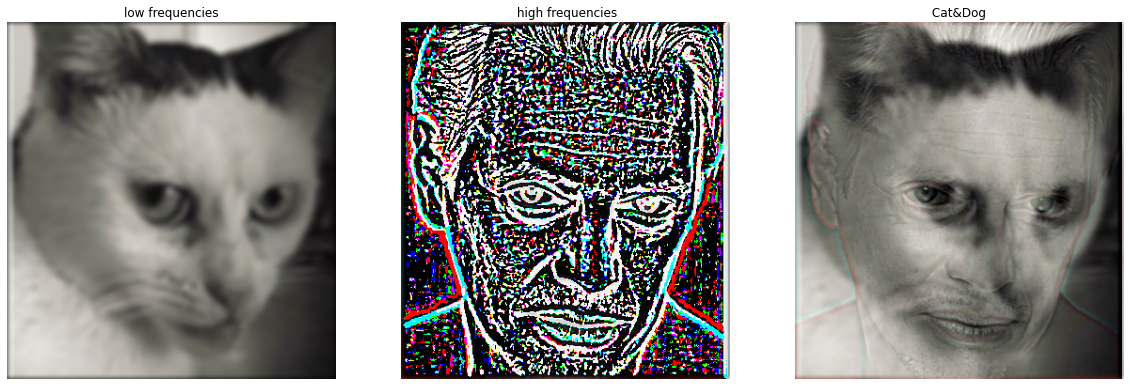

In [ ]:
image1  = cv2.imread('./data/pair6/cat.jpg')
image2  = cv2.imread('./data/pair6/man.jpg')
#out_gray = im_filter(normalize_image(grayscale), filter)
low_frequencies, high_frequencies, hybrid_image6 = gen_hybrid_image(image1, image2, 0.7, 11)

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([low_frequencies, high_frequencies, hybrid_image6 ], ['low frequencies',' high frequencies',' Cat&Dog '], 1, 3, 'bgr')

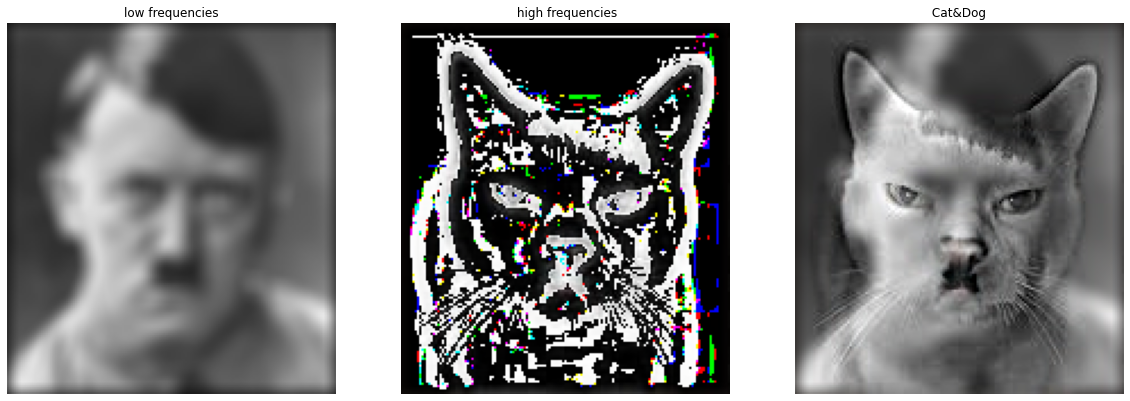

In [ ]:
image2  = cv2.imread('./data/pair7/cat.jpg')
image1  = cv2.imread('./data/pair7/H.jpg')
#out_gray = im_filter(normalize_image(grayscale), filter)
low_frequencies, high_frequencies, hybrid_image7 = gen_hybrid_image(image1, image2, 0.8, 11)

# plot the three images
plt.figure(figsize=(20, 20))
plot_figure([low_frequencies, high_frequencies, hybrid_image7 ], ['low frequencies',' high frequencies',' Cat&Dog '], 1, 3, 'bgr')

##Visualization Of Results

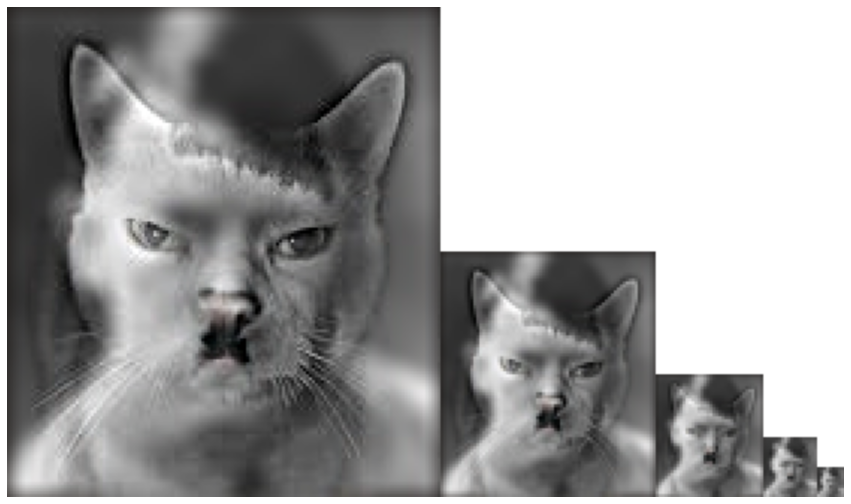

In [ ]:
vis_hybrid_image(hybrid_image7)

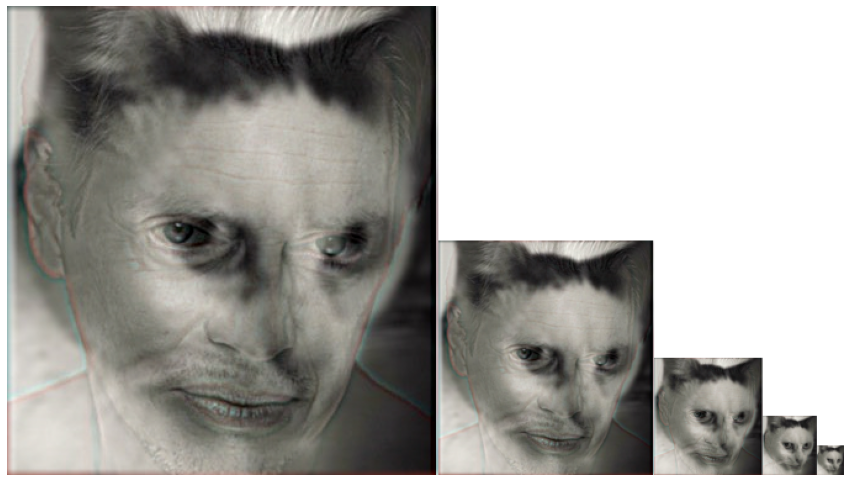

In [ ]:
vis_hybrid_image(hybrid_image6)

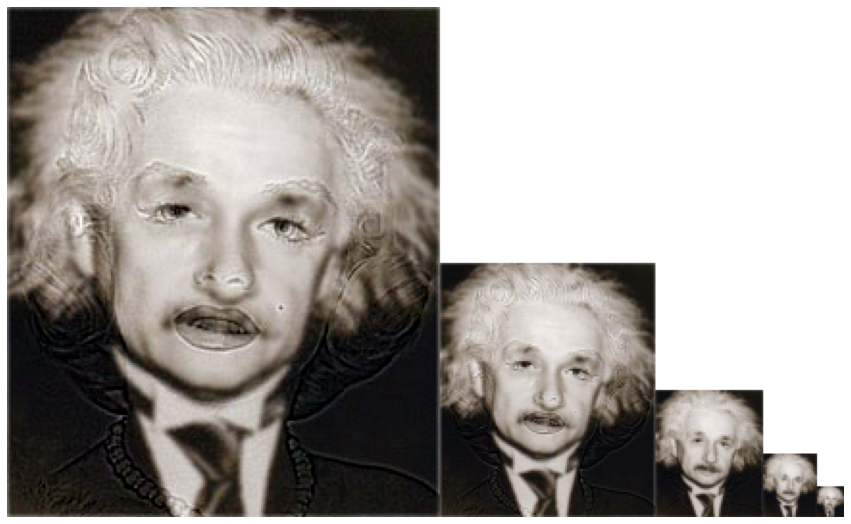

In [ ]:
vis_hybrid_image(hybrid_image2)

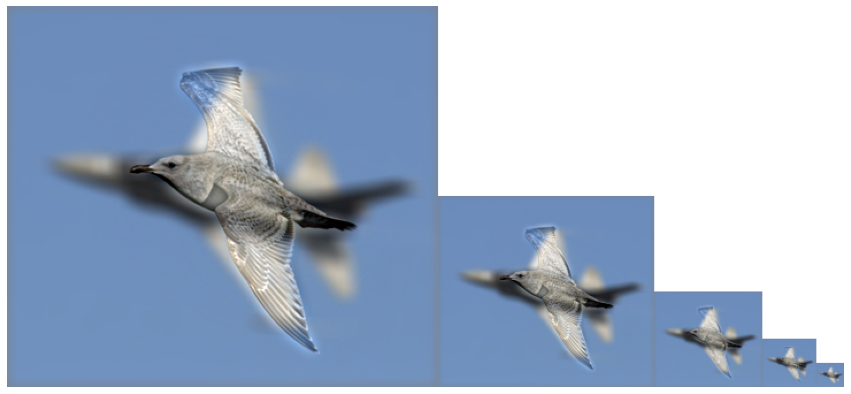

In [ ]:
vis_hybrid_image(hybrid_image4)

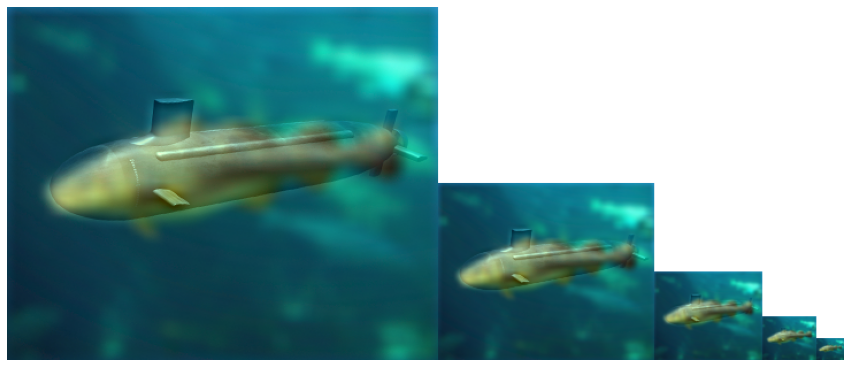

In [ ]:
vis_hybrid_image(hybrid_image3)

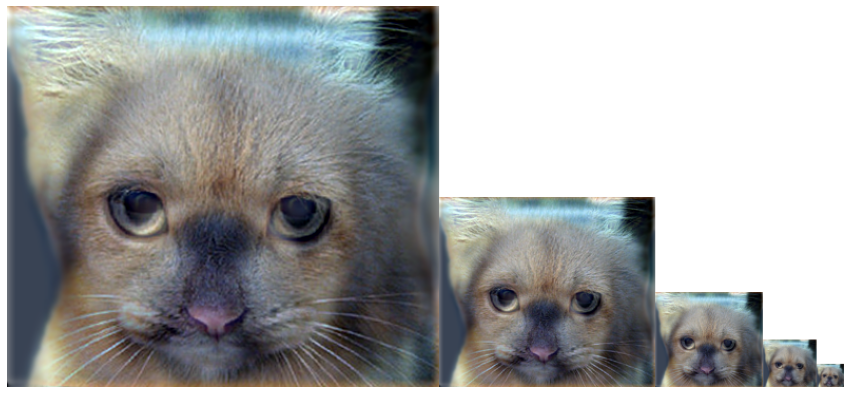

In [ ]:
vis_hybrid_image(hybrid_image5)

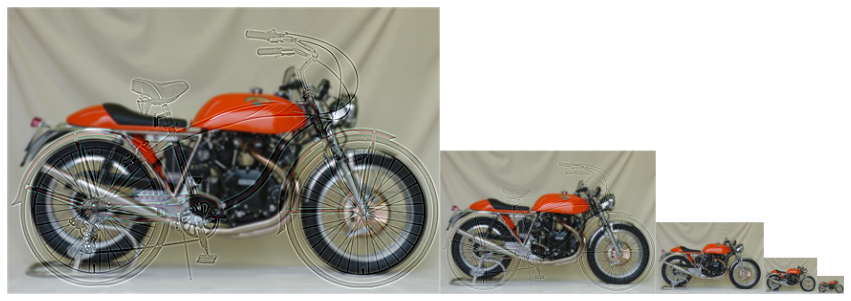

In [ ]:
vis_hybrid_image(hybrid_image1)

#Write_up Codes

##Q2

In [ ]:
a = np.asarray([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]], dtype=np.float32)
kernel = np.asarray([[-1, 0, 0], [0, 0, 0], [1, 0, 0]], dtype=np.float32)

corr_out = correlate(a, kernel, mode='constant')

conv_out = convolve(a, kernel, mode='constant')

print(corr_out)
print()
print(conv_out)

[[ 0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. -1. -1. -1. -1.]]

[[-1. -1. -1. -1.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.]]


##Q3

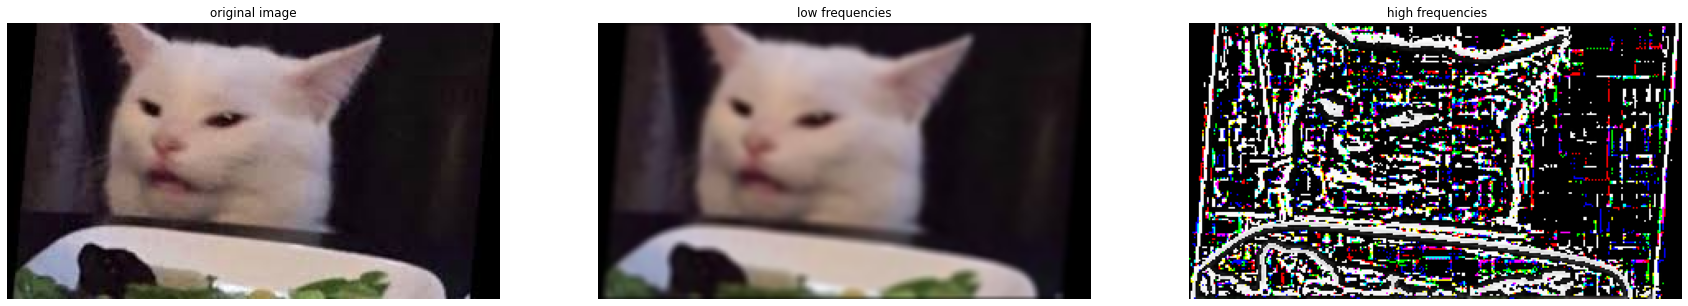

In [ ]:
# read image
img = cv2.imread('/content/whiteCatMeme.jpg')
# choose kernel size
ksize = 5
# create a mean filter
low_pass_filter = np.ones((ksize,ksize), dtype=np.float32)*(1/ksize**2)

# create a high pass filter from identity_filter - mean filter
identity_filter = np.zeros((ksize,ksize), dtype=np.float32)
identity_filter[int((ksize-1)/2), int((ksize-1)/2)] = 1
high_pass_filter = identity_filter-low_pass_filter

# filter the image using created kernels
low_frequencies = im_filter_fft(img, low_pass_filter)
high_frequencies =  im_filter_fft(img, high_pass_filter)

plt.figure(figsize=(30, 30))
plot_figure([img ,low_frequencies, high_frequencies], ['original image' ,'low frequencies',' high frequencies'], 1, 3, 'bgr')

##Q4

In [ ]:
img = cv2.imread('/content/RISDance.jpg')

kernel_sizes = list(range(3, 15+1, 2))
scales = list(np.linspace(0.175, 1, 20))
X=[]
Y=[]
Z=[]

for i in range(len(kernel_sizes)):
  for scale in range(len(scales)):
    kernel = np.ones((kernel_sizes[i], kernel_sizes[i]))
    res = rescale(img, scales[scale], mode='reflect', channel_axis=2)
    st = time.time()

    convolve(res[:, :, 0], kernel, mode='constant')
    convolve(res[:, :, 1], kernel, mode='constant')
    convolve(res[:, :, 2], kernel, mode='constant')

    et = time.time()

    X.append(kernel_sizes[i])
    Y.append((res.shape[0]*res.shape[1])/1e6)
    Z.append(et - st)

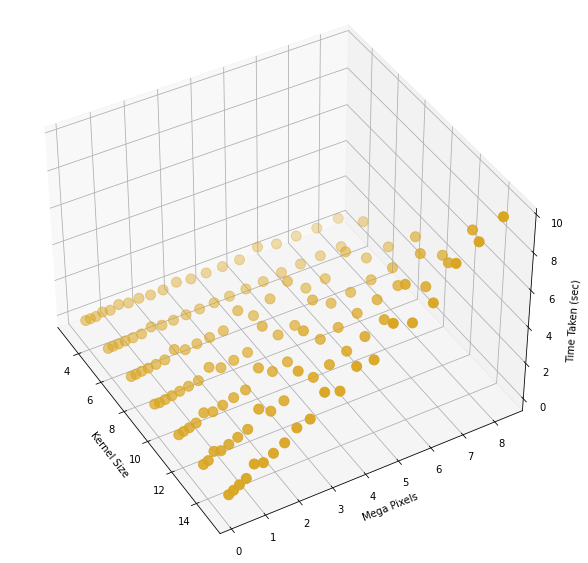

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_xlabel(u'Kernel Size')
ax.set_ylabel(u'Mega Pixels')
ax.set_zlabel(u'Time Taken (sec)')
Axes3D.scatter(ax, xs=X, ys=Y, zs=Z, c= "goldenrod",  s=100)
ax.view_init(40, -30)